## InceptonResNetV2-fine-tuning-V3
整体说明：
- 使用keras的InceptonResNetV2预训练模型进行fine-tuning，分别进行下面四种情况的fine-tuning
- 1、只训练自定义的输出层
- 2、冻结前698层，训练后面的层
- 3、冻结前618层，训练后面的层
- 4、冻结前499层，训练后面的层  
看哪种情况效果最好

修改内容：  
- 1、Dense增加正则项
- 2、DropOut参数改成0.5
- 3、callbacks_list增加EarlyStopping，增加epochs，统一用epochs=20，利用EarlyStopping控制结束时机
- 4、改predict_on_model，test数据加内存，一次性完成

In [1]:
'''
数据目录结构：
data/
    train/    #原始数据，train.zip解压后生成
        dog.0.jpg
        cat.0.jpg
        ...
    train2/   #按标签分目录后的数据（连接文件）
        dog/
            dog.0.jpg
            dog.1.jpg
            ...
        cat/
            cat.0.jpg
            cat.1.jpg
            ...
    train3/   #去除异常图片后的训练数据（连接文件）
        dog/    #9983张图片
            dog.0.jpg
            dog.1.jpg
            ...
        cat/    #9961张图片
            cat.0.jpg
            cat.1.jpg
            ...
    validation/  #去除异常图片后的验证数据（连接文件）
        dog/   #2496张图片
            dog001.jpg
            dog002.jpg
            ...
        cat/   #2490张图片
            cat001.jpg
            cat002.jpg
            ...
    test/     
        test/  #测试集数据，12500张图片
            1.jpg
            2.jpg
            ...
'''
import cv2
import time
import pandas as pd
from tqdm import tqdm   #进度条
from PIL import Image
from helper import *

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.optimizers import *
from keras.utils import *
from sklearn.utils import shuffle

# dimensions of our images.
img_width, img_height = 299, 299

train_data_dir = 'data/train2'
test_data_dir='data/test'


batch_size = 72   #19944/72=277  4986/72=69.25
epochs=20
VER=3
#模型权重文件
model_h5file_base="InceptonResNetV2-base-tuning-v{}.h5".format(VER)
model_h5file_tunig1="InceptonResNetV2-fine-tuning-1-v{}.h5".format(VER)
model_h5file_tunig2="InceptonResNetV2-fine-tuning-2-v{}.h5".format(VER)
model_h5file_tunig3="InceptonResNetV2-fine-tuning-3-v{}.h5".format(VER)

#预测结果文件
pred_file_base="pred-InceptonResNetV2-base-tuning-v{}.csv".format(VER)
pred_file_tuning1="pred-InceptonResNetV2-fine-tuning-1-v{}.csv".format(VER)
pred_file_tuning2="pred-InceptonResNetV2-fine-tuning-2-v{}.csv".format(VER)
pred_file_tuning3="pred-InceptonResNetV2-fine-tuning-3-v{}.csv".format(VER)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#构造InceptionResNetV2模型
start = time.clock()
x_input = Input((img_width, img_height, 3))
x_input = Lambda(inception_resnet_v2.preprocess_input)(x_input)

base_model = InceptionResNetV2(input_tensor=x_input, weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3), pooling = 'avg')
for layer in base_model.layers:
    layer.trainable = False
    
y = Dropout(0.5)(base_model.output) #0.25-->0.5
y = Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001))(y)  #增加正则项
model = Model(inputs=base_model.input, outputs=y)

print("Load base model used time:", (time.clock() - start))


Load base model used time: 36.435678


In [3]:
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam,
             loss='binary_crossentropy',
             metrics=['accuracy'])


In [4]:
# 输出模型结构图
#plot_model(model, to_file='model_InceptionResNetV2.png')

In [5]:
#生成数据--全量读入内存
#X_train, Y_train=read_images_to_memory(train_data_dir, img_width, img_height, test=True)
#训练数据
X_train, Y_train=read_images_to_memory(train_data_dir, img_width, img_height)
X_train, Y_train=shuffle(X_train, Y_train)

#测试数据
X_test = load_test_data(12500, img_height, img_width, test_data_dir)


  0%|          | 28/12479 [00:00<00:44, 276.79it/s]

dog_nums=12479, cat_nums=12451
total images: 24930


100%|██████████| 12500/12500 [01:28<00:00, 140.91it/s]


In [6]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_181 (BatchN (None, 8, 8, 192)    576         conv2d_181[0][0]                 
__________________________________________________________________________________________________
activation_181 (Activation)     (None, 8, 8, 192)    0           batch_normalization_181[0][0]    
__________________________________________________________________________________________________
conv2d_182 (Conv2D)             (None, 8, 8, 224)    129024      activation_181[0][0]             
__________________________________________________________________________________________________
batch_normalization_182 (BatchN (None, 8, 8, 224)    672         conv2d_182[0][0]                 
__________________________________________________________________________________________________
activation_182 (Activation)     (None, 8, 8, 224)    0           batch_normalization_182[0][0]    
__________

In [7]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_base, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min') #如发现loss相比上一个epoch训练没有下降,则经过3个epoch后停止训练
callbacks_list = [stopping,checkpoint]

history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/20
19944/19944 [==============================] - 138s 7ms/step - loss: 0.5237 - acc: 0.7654 - val_loss: 0.3232 - val_acc: 0.9017

Epoch 00001: val_loss improved from inf to 0.32325, saving model to InceptonResNetV2-base-tuning-v3.h5
Epoch 2/20
19944/19944 [==============================] - 124s 6ms/step - loss: 0.3448 - acc: 0.9051 - val_loss: 0.2131 - val_acc: 0.9525

Epoch 00002: val_loss improved from 0.32325 to 0.21312, saving model to InceptonResNetV2-base-tuning-v3.h5
Epoch 3/20
19944/19944 [==============================] - 124s 6ms/step - loss: 0.2634 - acc: 0.9376 - val_loss: 0.1642 - val_acc: 0.9693

Epoch 00003: val_loss improved from 0.21312 to 0.16419, saving model to InceptonResNetV2-base-tuning-v3.h5
Epoch 4/20
19944/19944 [==============================] - 124s 6ms/step - loss: 0.2178 - acc: 0.9484 - val_loss: 0.1431 - val_acc: 0.9695

Epoch 00004: val_loss improved from 0.16419 to 0.14314, saving model to Incept

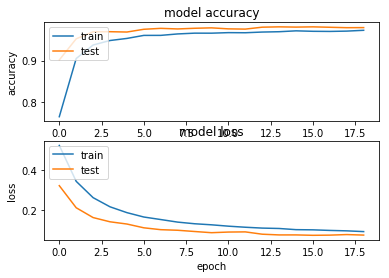

In [8]:
#可视化学习曲线
show_learning_curve(history)

In [11]:
#预测结果    
predict_on_model(X_test, model, model_h5file_base, pred_file_base)

12500/12500 [==============================] - 60s 5ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 12500/12500 [00:00<00:00, 147146.67it/s]


## 冻结前698层，再训练
放开Inception-resnet-C第5个block之后的层，不含Inception-resnet-C_5  
698 block8_5_ac 

In [13]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=698)

0 input_1
1 lambda_1
2 conv2d_1
3 batch_normalization_1
4 activation_1
5 conv2d_2
6 batch_normalization_2
7 activation_2
8 conv2d_3
9 batch_normalization_3
10 activation_3
11 max_pooling2d_1
12 conv2d_4
13 batch_normalization_4
14 activation_4
15 conv2d_5
16 batch_normalization_5
17 activation_5
18 max_pooling2d_2
19 conv2d_9
20 batch_normalization_9
21 activation_9
22 conv2d_7
23 conv2d_10
24 batch_normalization_7
25 batch_normalization_10
26 activation_7
27 activation_10
28 average_pooling2d_1
29 conv2d_6
30 conv2d_8
31 conv2d_11
32 conv2d_12
33 batch_normalization_6
34 batch_normalization_8
35 batch_normalization_11
36 batch_normalization_12
37 activation_6
38 activation_8
39 activation_11
40 activation_12
41 mixed_5b
42 conv2d_16
43 batch_normalization_16
44 activation_16
45 conv2d_14
46 conv2d_17
47 batch_normalization_14
48 batch_normalization_17
49 activation_14
50 activation_17
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 batch_normalization_13
55 batch_normalization_15
56 batch_n

In [14]:
model.load_weights(model_h5file_base)
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [15]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_tunig1, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min') #如发现loss相比上一个epoch训练没有下降,则经过3个epoch后停止训练
callbacks_list = [stopping,checkpoint]

history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/20
19944/19944 [==============================] - 127s 6ms/step - loss: 0.1011 - acc: 0.9712 - val_loss: 0.0742 - val_acc: 0.9809

Epoch 00001: val_loss improved from inf to 0.07425, saving model to InceptonResNetV2-fine-tuning-1-v3.h5
Epoch 2/20
19944/19944 [==============================] - 128s 6ms/step - loss: 0.0972 - acc: 0.9724 - val_loss: 0.0710 - val_acc: 0.9826

Epoch 00002: val_loss improved from 0.07425 to 0.07097, saving model to InceptonResNetV2-fine-tuning-1-v3.h5
Epoch 3/20
19944/19944 [==============================] - 128s 6ms/step - loss: 0.0959 - acc: 0.9713 - val_loss: 0.0772 - val_acc: 0.9793

Epoch 00003: val_loss did not improve from 0.07097
Epoch 4/20
19944/19944 [==============================] - 128s 6ms/step - loss: 0.0922 - acc: 0.9731 - val_loss: 0.0729 - val_acc: 0.9803

Epoch 00004: val_loss did not improve from 0.07097
Epoch 5/20
19944/19944 [==============================] - 128s 6ms/step - loss:

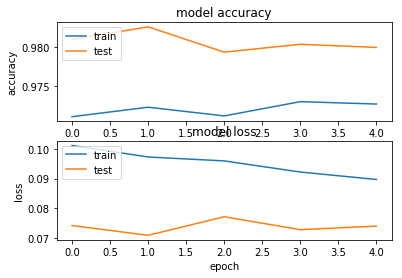

In [16]:
#可视化学习曲线
show_learning_curve(history)

In [18]:
#预测结果
predict_on_model(X_test, model, model_h5file_tunig1, pred_file_tuning1)

12500/12500 [==============================] - 69s 6ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 12500/12500 [00:00<00:00, 152408.86it/s]


## 冻结前618层，再训练
放开Reduction-B之后的层，不含Reduction-B  
618 mixed_7a

In [19]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=618)

0 input_1
1 lambda_1
2 conv2d_1
3 batch_normalization_1
4 activation_1
5 conv2d_2
6 batch_normalization_2
7 activation_2
8 conv2d_3
9 batch_normalization_3
10 activation_3
11 max_pooling2d_1
12 conv2d_4
13 batch_normalization_4
14 activation_4
15 conv2d_5
16 batch_normalization_5
17 activation_5
18 max_pooling2d_2
19 conv2d_9
20 batch_normalization_9
21 activation_9
22 conv2d_7
23 conv2d_10
24 batch_normalization_7
25 batch_normalization_10
26 activation_7
27 activation_10
28 average_pooling2d_1
29 conv2d_6
30 conv2d_8
31 conv2d_11
32 conv2d_12
33 batch_normalization_6
34 batch_normalization_8
35 batch_normalization_11
36 batch_normalization_12
37 activation_6
38 activation_8
39 activation_11
40 activation_12
41 mixed_5b
42 conv2d_16
43 batch_normalization_16
44 activation_16
45 conv2d_14
46 conv2d_17
47 batch_normalization_14
48 batch_normalization_17
49 activation_14
50 activation_17
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 batch_normalization_13
55 batch_normalization_15
56 batch_n

In [22]:
model.load_weights(model_h5file_base) 
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_tunig2, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min') #如发现loss相比上一个epoch训练没有下降,则经过3个epoch后停止训练
callbacks_list = [stopping,checkpoint]
history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/20
19944/19944 [==============================] - 136s 7ms/step - loss: 0.1024 - acc: 0.9698 - val_loss: 0.0782 - val_acc: 0.9793

Epoch 00001: val_loss improved from inf to 0.07822, saving model to InceptonResNetV2-fine-tuning-2-v3.h5
Epoch 2/20
19944/19944 [==============================] - 128s 6ms/step - loss: 0.0998 - acc: 0.9692 - val_loss: 0.0730 - val_acc: 0.9809

Epoch 00002: val_loss improved from 0.07822 to 0.07296, saving model to InceptonResNetV2-fine-tuning-2-v3.h5
Epoch 3/20
19944/19944 [==============================] - 128s 6ms/step - loss: 0.0966 - acc: 0.9710 - val_loss: 0.0753 - val_acc: 0.9797

Epoch 00003: val_loss did not improve from 0.07296
Epoch 4/20
19944/19944 [==============================] - 128s 6ms/step - loss: 0.0953 - acc: 0.9716 - val_loss: 0.0666 - val_acc: 0.9844

Epoch 00004: val_loss improved from 0.07296 to 0.06661, saving model to InceptonResNetV2-fine-tuning-2-v3.h5
Epoch 5/20
19944/1994

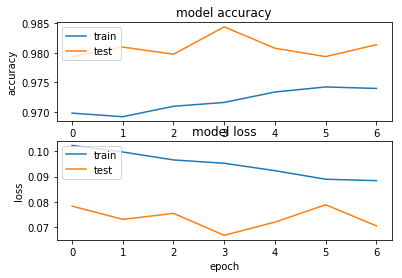

In [24]:
#可视化学习曲线
show_learning_curve(history)

In [25]:
#预测结果
predict_on_model(X_test, model, model_h5file_tunig2, pred_file_tuning2)

12500/12500 [==============================] - 75s 6ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 12500/12500 [00:00<00:00, 148211.97it/s]


## 冻结前746层，再训练
放开Inception-resnet-C 第8个block之后的层，不含包Inception-resnet-C_8  
746 block8_8_ac

In [26]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=746)

0 input_1
1 lambda_1
2 conv2d_1
3 batch_normalization_1
4 activation_1
5 conv2d_2
6 batch_normalization_2
7 activation_2
8 conv2d_3
9 batch_normalization_3
10 activation_3
11 max_pooling2d_1
12 conv2d_4
13 batch_normalization_4
14 activation_4
15 conv2d_5
16 batch_normalization_5
17 activation_5
18 max_pooling2d_2
19 conv2d_9
20 batch_normalization_9
21 activation_9
22 conv2d_7
23 conv2d_10
24 batch_normalization_7
25 batch_normalization_10
26 activation_7
27 activation_10
28 average_pooling2d_1
29 conv2d_6
30 conv2d_8
31 conv2d_11
32 conv2d_12
33 batch_normalization_6
34 batch_normalization_8
35 batch_normalization_11
36 batch_normalization_12
37 activation_6
38 activation_8
39 activation_11
40 activation_12
41 mixed_5b
42 conv2d_16
43 batch_normalization_16
44 activation_16
45 conv2d_14
46 conv2d_17
47 batch_normalization_14
48 batch_normalization_17
49 activation_14
50 activation_17
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 batch_normalization_13
55 batch_normalization_15
56 batch_n

563 block17_18_ac
564 conv2d_150
565 batch_normalization_150
566 activation_150
567 conv2d_151
568 batch_normalization_151
569 activation_151
570 conv2d_149
571 conv2d_152
572 batch_normalization_149
573 batch_normalization_152
574 activation_149
575 activation_152
576 block17_19_mixed
577 block17_19_conv
578 block17_19
579 block17_19_ac
580 conv2d_154
581 batch_normalization_154
582 activation_154
583 conv2d_155
584 batch_normalization_155
585 activation_155
586 conv2d_153
587 conv2d_156
588 batch_normalization_153
589 batch_normalization_156
590 activation_153
591 activation_156
592 block17_20_mixed
593 block17_20_conv
594 block17_20
595 block17_20_ac
596 conv2d_161
597 batch_normalization_161
598 activation_161
599 conv2d_157
600 conv2d_159
601 conv2d_162
602 batch_normalization_157
603 batch_normalization_159
604 batch_normalization_162
605 activation_157
606 activation_159
607 activation_162
608 conv2d_158
609 conv2d_160
610 conv2d_163
611 batch_normalization_158
612 batch_normali

In [27]:
model.load_weights(model_h5file_base) 
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [28]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_tunig3, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min') #如发现loss相比上一个epoch训练没有下降,则经过3个epoch后停止训练
callbacks_list = [stopping,checkpoint]

history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)


Train on 19944 samples, validate on 4986 samples
Epoch 1/20
19944/19944 [==============================] - 137s 7ms/step - loss: 0.1002 - acc: 0.9711 - val_loss: 0.0754 - val_acc: 0.9803

Epoch 00001: val_loss improved from inf to 0.07542, saving model to InceptonResNetV2-fine-tuning-3-v3.h5
Epoch 2/20
19944/19944 [==============================] - 129s 6ms/step - loss: 0.0987 - acc: 0.9719 - val_loss: 0.0797 - val_acc: 0.9789

Epoch 00002: val_loss did not improve from 0.07542
Epoch 3/20
19944/19944 [==============================] - 129s 6ms/step - loss: 0.0957 - acc: 0.9726 - val_loss: 0.0824 - val_acc: 0.9781

Epoch 00003: val_loss did not improve from 0.07542
Epoch 4/20
19944/19944 [==============================] - 129s 6ms/step - loss: 0.0929 - acc: 0.9732 - val_loss: 0.0750 - val_acc: 0.9797

Epoch 00004: val_loss improved from 0.07542 to 0.07503, saving model to InceptonResNetV2-fine-tuning-3-v3.h5
Epoch 5/20
19944/19944 [==============================] - 128s 6ms/step - loss:

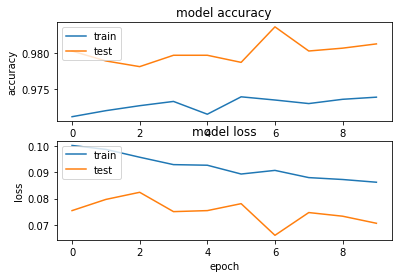

In [29]:
#可视化学习曲线
show_learning_curve(history)

In [30]:
#预测结果
predict_on_model(X_test, model, model_h5file_tunig3, pred_file_tuning3)

12500/12500 [==============================] - 75s 6ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 12500/12500 [00:00<00:00, 148651.53it/s]
